In [1]:
import numpy as np
import matplotlib.cm as cmap
import matplotlib.pyplot as plt
import time
import os.path
import scipy
import pickle as pickle
from struct import unpack
from brian2 import *
import brian2
from brian2tools import *
from PIL import Image
import scipy.signal as signal
import warnings
warnings.simplefilter('ignore')
import random

In [2]:
def get_surrounding(coordinate, inner, outer, length):
    y = coordinate[0]
    x = coordinate[1]
    out_x_min = 0 if (x-outer < 0) else (x-outer)
    out_x_max = (length-1) if (x+outer > length-1) else (x+outer)
    out_y_min = 0 if (y-outer < 0) else (y-outer)
    out_y_max = (length-1) if (y+outer > length-1) else (y+outer)
    
    in_x_min = 0 if (x-inner < 0) else (x-inner)
    in_x_max = (length-1) if (x+inner > length-1) else (x+inner)
    in_y_min = 0 if (y-inner < 0) else (y-inner)
    in_y_max = (length-1) if (y+inner > length-1) else (y+inner)
    
#     print(out_x_min, out_x_max, out_y_min, out_y_max)
#     print(in_x_min, in_x_max, in_y_min, in_y_max)
    
    coordinates = []
    for i in range(out_y_min, out_y_max+1):
        for j in range(out_x_min, out_x_max+1):
            if ((i not in range(in_y_min, in_y_max+1)) or (j not in range(in_x_min, in_x_max+1))):
                if (not (y==i and x==j)):
                    coordinates.append((i,j))
    return coordinates

In [3]:
# initial random weights
dataPath = './initial_weights/'

field_size = 2                     # 2/3/4/5/6
w_s = field_size*1                # simple cell width
l_s = field_size*2                # simple_cell_length

c_length = 30
r_length = (c_length*l_s)   # (c_length*2*w_s)
orientations = 4

n_LGN = r_length*r_length
n_L4  = c_length*c_length
n_L3  = n_L4
n_L2  = n_L3

weight = {}
weight['LGN_L4'] = 10
weight['L4_L4'] = 25
weight['L4_L3_round'] = 1
weight['L4_L3_direct'] = 25
weight['L3_L3'] = 7
weight['L3_L2'] = 7
weight['L2_L3'] = 15

In [4]:
# orientation map generations

grid = np.rint(np.random.random((c_length, c_length)) * (orientations-1))
counter = 1
while(True):
    counts = np.sort(np.unique(grid, return_counts=True)[1])
    if ( (counts[-1] < n_L4/(orientations-1)) and (counts[0] > n_L4/(orientations+1.5)) ):
        break
    grid = np.rint(np.random.random((c_length, c_length)) * (orientations-1))
    counter += 1
    
counts = np.unique(grid, return_counts=True)[1]
d1_index, d2_index, v_index, h_index = counts.argsort()

print('h', h_index, counts[h_index])
print('v', v_index, counts[v_index])
print('d2', d2_index, counts[d2_index])
print('d1', d1_index, counts[d1_index])

h 2 297
v 1 268
d2 3 170
d1 0 165


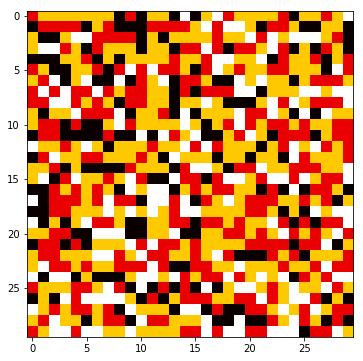

In [5]:
figure(figsize = (6,6))
im2 = imshow(grid, cmap = cmap.get_cmap('hot'))
# colorbar(im2)

In [6]:
# LGN ON >> L4 horizontal   (NF connection)
# LGN OFF >> L4 horizontal  (FN connection)

weightList = np.random.random((n_LGN, n_L4))
weightList += weight['LGN_L4']

weights_NF = []
weights_FN = []

for i in range(0, c_length):
    for j in range(0, c_length):
        
        if (grid[i][j] == h_index):
            for p in range(0, w_s):
                for q in range(0, l_s):
                    x_NF = (i*2*w_s+p) * r_length + (j*l_s+q)
                    x_FN = ((i*2+1)*w_s+p) * r_length + (j*l_s+q)
                    y = i * c_length + j

                    weights_NF.append((x_NF, y, weightList[x_NF,y]))
                    weights_FN.append((x_FN, y, weightList[x_FN,y]))
            
        elif (grid[i][j] == v_index):
            for p in range(0, l_s):
                for q in range(0, w_s):
                    x_NF = (i*l_s+p) * r_length + (j*2*w_s+q)
                    x_FN = (i*l_s+p) * r_length + ((j*2+1)*w_s+q)
                    y = i * c_length + j

                    weights_NF.append((x_NF, y, weightList[x_NF,y]))
                    weights_FN.append((x_FN, y, weightList[x_FN,y]))
            
        elif (grid[i][j] == d1_index):
            x_NF_list = [
                (i*l_s+0)*r_length + (j*2*w_s+0), (i*l_s+0)*r_length + (j*2*w_s+1), (i*l_s+0)*r_length + (j*2*w_s+2),
                (i*l_s+1)*r_length + (j*2*w_s+0), (i*l_s+1)*r_length + (j*2*w_s+1),
                (i*l_s+2)*r_length + (j*2*w_s+0)
            ]
            x_FN_list = [
                (i*l_s+1)*r_length + (j*2*w_s+3),
                (i*l_s+2)*r_length + (j*2*w_s+2), (i*l_s+2)*r_length + (j*2*w_s+3),
                (i*l_s+3)*r_length + (j*2*w_s+1), (i*l_s+3)*r_length + (j*2*w_s+2), (i*l_s+3)*r_length + (j*2*w_s+3)
            ]
            y = i * c_length + j

            for x_NF in x_NF_list:
                weights_NF.append((x_NF, y, weightList[x_NF,y]))
            for x_FN in x_FN_list:
                weights_FN.append((x_FN, y, weightList[x_FN,y]))
            
        elif (grid[i][j] == d2_index):
            x_NF_list = [
                (i*l_s+0)*r_length + (j*2*w_s+1), (i*l_s+0)*r_length + (j*2*w_s+2), (i*l_s+0)*r_length + (j*2*w_s+3),
                (i*l_s+1)*r_length + (j*2*w_s+2), (i*l_s+1)*r_length + (j*2*w_s+3),
                (i*l_s+2)*r_length + (j*2*w_s+3)
            ]
            x_FN_list = [
                (i*l_s+1)*r_length + (j*2*w_s+0),
                (i*l_s+2)*r_length + (j*2*w_s+0), (i*l_s+2)*r_length + (j*2*w_s+1),
                (i*l_s+3)*r_length + (j*2*w_s+0), (i*l_s+3)*r_length + (j*2*w_s+1), (i*l_s+3)*r_length + (j*2*w_s+2)
            ]
            y = i* c_length + j

            for x_NF in x_NF_list:
                weights_NF.append((x_NF, y, weightList[x_NF,y]))
            for x_FN in x_FN_list:
                weights_FN.append((x_FN, y, weightList[x_FN,y]))   
        
np.save(dataPath + 'LGN_L4_NF', weights_NF)
np.save(dataPath + 'LGN_L4_FN', weights_FN)

In [7]:
# L4 >> L4
# one to one

weightList = np.random.random(n_L4)
weightList += weight['L4_L4']
weights = [(i, i, weightList[i]) for i in range(n_L4)]
np.save(dataPath + 'L4_L4', weights)

In [8]:
# L4 >> L2/3 (L3)
# many to one (circle + direct)
# excitatory vertical forward connections

weight_direct_list  = np.random.random(n_L4)
weight_direct_list += weight['L4_L3_direct']

weights = [(k, k, weight_direct_list[k]) for k in range(n_L4)]

# weights = []

weight_round_list   = np.random.random((n_L4, n_L3))
weight_round_list  += weight['L4_L3_round']

for i in range(0, c_length):                   # y axis
    for j in range(0, c_length):               # x axis
        for p,q in get_surrounding((i,j), 0, 1, c_length):
            source = p * c_length + q
            target = i * c_length + j
            weights.append((source, target, weight_round_list[source,target]))
                 
np.save(dataPath + 'L4_L3', weights)

In [9]:
# L2/3 (L3) >> L2/3 (L3)
# many to one (circle)
# excitatory horizontal connections

weightList  = np.random.random((n_L3, n_L2))
weightList += weight['L3_L3']

weights = []

for i in range(0, c_length):                   # y axis
    for j in range(0, c_length):               # x axis
        for p,q in get_surrounding((i,j), 0, 2, c_length):
            target = p * c_length + q
            source = i * c_length + j
            weights.append((source, target, weightList[source,target]))
                 
np.save(dataPath + 'L3_L3', weights)

In [10]:
# L2/3 (L3) >> L2/3 (L2)
# many to one (circle)
# excitatory horizontal connections

weightList  = np.random.random((n_L3, n_L2))
weightList += weight['L3_L2']

weights = []

for i in range(0, c_length):                   # y axis
    for j in range(0, c_length):               # x axis
        for p,q in get_surrounding((i,j), 2, 4, c_length):
            source = p * c_length + q
            target = i * c_length + j
            weights.append((source, target, weightList[source,target]))
                 
np.save(dataPath + 'L3_L2', weights)

In [11]:
# L2/3 (L2) >> L2/3 (L3)
# one to one
# inhibitory vertical connections

weightList = np.random.random(n_L2)
weightList += weight['L2_L3']
weights = [(i, i, weightList[i]) for i in range(n_L2)]
np.save(dataPath + 'L2_L3', weights)

In [12]:
# # L2/3 (L3) >> L4
# # many to one (circle)
# # excitatory feedback vertical connections

# weightList  = np.random.random((n_L3, n_L4))
# weightList += weight['L3_L2']

# weights = []

# for i in range(0, c_length):                   # y axis
#     for j in range(0, c_length):               # x axis
#         for p,q in get_surrounding((i,j), 2, 4, c_length):
#             source = p * c_length + q
#             target = i * c_length + j
#             weights.append((source, target, weightList[source,target]))
                 
# np.save(dataPath + 'L3_L2', weights)